In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics

import numpy as np

import os
import pathlib
import matplotlib.pyplot as plt

In [2]:
NCLASSES = 2
HEIGHT = 50
WIDTH = 50
NUM_CHANNELS = 3
BATCH_SIZE = 32

DATA_SET_COUNT = 27558
TEST_SET_COUNT = (DATA_SET_COUNT)*0.2
TRAIN_SET_COUNT = (DATA_SET_COUNT) * 0.6
VAL_SET_COUNT = (DATA_SET_COUNT) * 0.2
print(TEST_SET_COUNT,TRAIN_SET_COUNT, VAL_SET_COUNT)

5511.6 16534.8 5511.6


Auxiliary function for loading the dataset

In [3]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == classNames

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [WIDTH, HEIGHT])

def get_bytes_and_label(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

Load the dataset, replace the path with your own location of the dataset

In [4]:
data_dir = pathlib.Path('C:/Users/paulo/OneDrive/Ambiente de Trabalho/Escola/Apendizagem automatica 2/Trabalho/AA2/input/cell_images')
  
classNames = np.array(os.listdir(data_dir))
classNames

AUTOTUNE = tf.data.experimental.AUTOTUNE

listset = tf.data.Dataset.list_files("C:/Users/paulo/OneDrive/Ambiente de Trabalho/Escola/Apendizagem automatica 2/Trabalho/AA2/input/cell_images/*/*.png")
dataset = listset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)


Data Augmentation

In [22]:
import random

#https://www.tensorflow.org/api_docs/python/tf/image
#https://www.tensorflow.org/addons/api_docs/python/tfa/image

#pip install tensorflow-addons
import tensorflow_addons as tfa


def process_image(image, label):
    
    #image = tf.image.resize(image, (64,64))
    
    delta = tf.random.uniform(shape=(), minval=0.01, maxval=1) * 0.5
    lower_saturation = 0.9 + tf.random.uniform(shape=(), minval=0, maxval=1) * 0.2
    upper_saturation = lower_saturation + tf.random.uniform(shape=(), minval=0, maxval=1) * 0.2
    lower_value = 0.9 + tf.random.uniform(shape=(), minval=0, maxval=1) * 0.3
    upper_value = lower_value + tf.random.uniform(shape=(), minval=0, maxval=1) * 0.4
    image = tfa.image.random_hsv_in_yiq(image, 0.3, 0.8, 1.1, 0.9, 1.3)
    
    #image = tf.image.resize(image, (32,32))
    #image = tf.clip_by_value(tf.image.adjust_brightness(image, tf.random.uniform(shape=(), minval=0, maxval=1)-0.2),0,1)
    image = tf.clip_by_value(tf.image.adjust_brightness(image, -0.2),0,1)
    return image, label

def rotate_image(image, label):
    #image = tf.image.resize(image, (64,64))
    
    r = tf.random.uniform(shape=(), minval=0, maxval=360)
    image = tfa.image.rotate(image, r)
    
    #image = tf.image.resize(image, (32,32))
    #image = tf.clip_by_value(tf.image.adjust_brightness(image, tf.random.uniform(shape=(), minval=0, maxval=1)-0.2),0,1)
    return image, label

def translate_image(image, label):
    #image = tf.image.resize(image, (64,64))
    
    rx = tf.random.uniform(shape=(), minval=0, maxval=1) * 14 - 7
    ry = tf.random.uniform(shape=(), minval=0, maxval=1) * 14 - 7
    image = tfa.image.translate(image, [rx, ry])
    
    #image = tf.image.resize(image, (32,32))
    #image = tf.clip_by_value(tf.image.adjust_brightness(image, tf.random.uniform(shape=(), minval=0, maxval=1)-0.2),0,1)
    return image, label

def increase_contrast_image(image, label):
    #image = tf.image.resize(image, (64,64))
    
    image=tf.image.adjust_contrast(image,2)
    
    #image = tf.image.resize(image, (32,32))
    #image = tf.clip_by_value(tf.image.adjust_brightness(image, tf.random.uniform(shape=(), minval=0, maxval=1)-0.2),0,1)
    return image, label

def decrease_contrast_image(image, label):
    #image = tf.image.resize(image, (64,64))
    
    image=tf.image.adjust_contrast(image,0.6)
    
    #image = tf.image.resize(image, (32,32))
    #image = tf.clip_by_value(tf.image.adjust_brightness(image, tf.random.uniform(shape=(), minval=0, maxval=1)-0.2),0,1)
    return image, label

Split the dataset into training, validation and tedt sets

In [23]:
dataset = dataset.prefetch(buffer_size=AUTOTUNE)
#dataset = dataset.batch(batch_size=BATCH_SIZE)
dataset = dataset.repeat()

train_size = int(TRAIN_SET_COUNT)
val_size = int(VAL_SET_COUNT)
test_size= int(TEST_SET_COUNT)

train_dataset = dataset.take(train_size)
#-Data Augmentation
d1= train_dataset.map(increase_contrast_image,num_parallel_calls=AUTOTUNE)
#d1= train_dataset.map(rotate_image,num_parallel_calls=AUTOTUNE)

NUM_MAPS_DATA_AUGMENT=1
train_size=train_size*NUM_MAPS_DATA_AUGMENT

#train_dataset=d1.concatenate(d2)
train_dataset=d1
#----
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(buffer_size = train_size)
train_dataset = train_dataset.batch(batch_size=BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
train_dataset = train_dataset.repeat();

test_dataset = dataset.skip(train_size)
test_dataset = test_dataset.take(test_size)
test_dataset = test_dataset.shuffle(buffer_size = train_size)
test_dataset = test_dataset.batch(batch_size=BATCH_SIZE)

val_dataset = dataset.skip(train_size+test_size)
val_dataset = val_dataset.cache()
val_dataset = val_dataset.batch(batch_size=BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.repeat();


Load the test set

In [24]:
testset = test_dataset


Show a batch of images from the dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

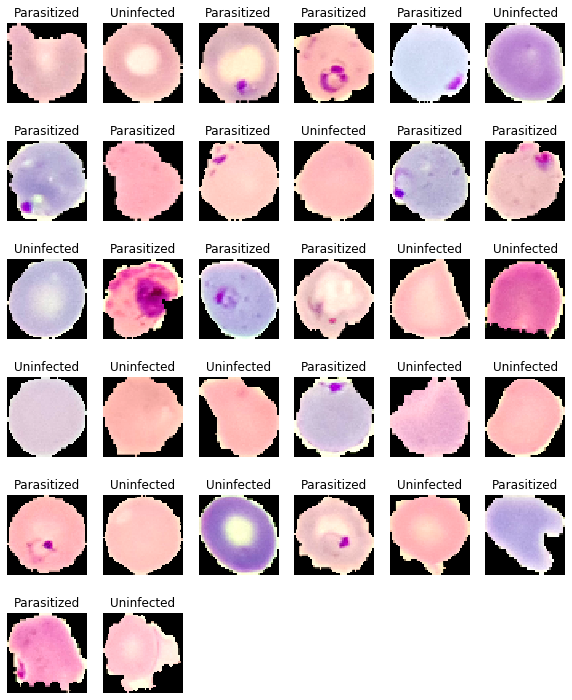

In [25]:
def show_batch(image_batch, label_batch):
  columns = 6
  rows = BATCH_SIZE / columns + 1  
  plt.figure(figsize=(10, 2 * rows))
  for n in range(BATCH_SIZE):
      ax = plt.subplot(rows, columns, n+1)
      plt.imshow((image_batch[n]))
      plt.title(classNames[label_batch[n]==1][0])
      plt.axis('off')
        
        
image_batch, label_batch = next(iter(train_dataset))  
show_batch(image_batch, label_batch.numpy())



Primeiros resultados com 30 epocas:
    Resultados -> [0.09822106476054887, 0.9724188]
    
    Resultados -> [0.09970240995915057, 0.9771366]
    
    Resultados -> [0.09709152765370195, 0.97913265]

OS graficos do treino tem muitos altos e baixos. vou tentar reduzir o step de 0.001 para 0.0005 aver se ajuda.

Como o número de epocas nao parece ter afetado, vou voltar a usar 20 epocas.

Resultados:
    
    Resultados -> [0.07556610100638832, 0.97913265]
    
    Resultados -> [0.11845710180743398, 0.97822535]
    
    Resultados -> [0.11034344812033152, 0.9831247]
    
Parece que melhorou. 

Vou aumentar a complexidade da rede depois do flatten. Vou por 512 256 128

Resultados -> [0.11262756224884517, 0.97749954]

Resultados -> [0.112837254023314, 0.9825803]

Resultados -> [0.1579071757994804, 0.9818545]

Não consigo perceber se melhorou ou não. Vou aumentar a complexidade das camadas conv2d a ver o que acontece. Ficou 256 128 64

Resultados -> [0.09519005841656314, 0.97913265]

Resultados -> [0.1559975825278033, 0.979677]

Resultados -> [0.12951020138670086, 0.9833061]

Vou correr mais uma vez para ver melhor os resultados.

Resultados -> [0.13078563809401567, 0.97659224]

Resultados -> [0.10909477567710346, 0.9840319]

Resultados -> [0.1473225694302675, 0.9825803]

Vou fazer data augmentation para ver se melhora. Dupliquei o tamanho do dataset, usando uma função para rodar as imagens, e outra para aumentar o contraste. Assim força a rede a ignorar a orientação das celulas e força a rede a focar-se na diferença de cores entre infetada e nao infetada.

Resultados -> [0.1550383184648878, 0.95717657]

Resultados -> [0.11947062133536862, 0.9664308]

Resultados -> [0.1277277860857783, 0.96842676]

Ficou pior. Vou tentar apenas com um dos maps de cada vez. Primeiro vou tentar com o aumentar contrast.

Resultados -> [0.20363568402073115, 0.93776083]

Resultados -> [0.24657452397038884, 0.9609871]

Resultados -> [0.2891723330340764, 0.9468336]

Ficou bastante pior. Vou testar com o outro.

Resultados -> [0.23375302097542114, 0.96407187]

Resultados -> [0.4722976528172342, 0.95481765]

Resultados -> [0.5312820033113527, 0.9499183]

Tanto o rotation, como o aumentar contraste poe os resultados piores.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam

train_size = int(TRAIN_SET_COUNT)
val_size = int(VAL_SET_COUNT)
test_size= int(TEST_SET_COUNT)

def cnn55D3L2FC(classCount, imgSize, channels):
    model = Sequential()
    
    model.add(Conv2D(256, (3, 3), padding='same',input_shape=(imgSize, imgSize, channels),activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (3, 3), activation='relu') ) 
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Conv2D(64, (3, 3), activation='relu') )   
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    

    model.add(Dense(classCount, activation='softmax'))

    
    opt = Adam(lr=0.0005)
    model.compile(optimizer = opt, loss='categorical_crossentropy', metrics=[ metrics.categorical_accuracy])
    return model

model = cnn55D3L2FC(2, 50, 3)

outs=[];
for x in range(3):

    history = model.fit(train_dataset, steps_per_epoch = train_size/BATCH_SIZE,epochs=20, validation_data = val_dataset, validation_steps= val_size/BATCH_SIZE)

    var=model.evaluate(test_dataset)
    outs.append("Resultados -> "+ str(var))
    
for s in outs:
    print (s)

Train for 516.6875 steps, validate for 172.21875 steps
Epoch 1/20
517/516 [==============================] - 100s 193ms/step - loss: 0.3970 - categorical_accuracy: 0.7948 - val_loss: 0.3562 - val_categorical_accuracy: 0.8696
Epoch 2/20
517/516 [==============================] - 101s 195ms/step - loss: 0.1480 - categorical_accuracy: 0.9520 - val_loss: 0.5112 - val_categorical_accuracy: 0.61940.9 - ETA: 20s - loss: 0.1549 - ca - ETA:  - ETA: 14s - loss: 0. - ETA: 11s  - ETA: 8s - loss: 0.1491 - ca - ETA - ETA: 3s - loss: 0.1 - ETA: 1s - loss: 0.1482 - categorical_accuracy: 0.95 - ETA: 1s -
Epoch 3/20
517/516 [==============================] - 101s 196ms/step - loss: 0.1381 - categorical_accuracy: 0.9562 - val_loss: 0.4507 - val_categorical_accuracy: 0.6942
Epoch 4/20
517/516 [==============================] - 100s 193ms/step - loss: 0.1273 - categorical_accuracy: 0.9588 - val_loss: 0.3736 - val_categorical_accuracy: 0.8331
Epoch 5/20
517/516 [==============================] - 110s 213ms/

In [ ]:
print(model.summary())

print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()